# PHYS 319 Project Final Report: 85888436 Harrison Li

# Kendama Moshikame performance analyzer
## Introduction
### Background Information
Kendama is a wooden traditional japanese toy, consists of a ken connected to a dama with a string. The ken has a spike on the top with 3 cups on the sides (big/small cups) and bottom (base cup), and the dama is essentially a ball with a hole. The player is supposed to use one hand to move the ball around and catch the ball with the cups or spike the ball with the ken.
- kendama image

The Japanese Kendama Association has a certification test that ranks the player's skill level, the ranks starts with 10 beginner levels from 10 to 1 "Kyu" to one intermediate level "Junshodan" to 10 advanced levels from 1 to 10 "Dan". Moshikame is one of kendama tricks that will be tested in order to proceed to the next ranking. Moshikame involves moving the ball between the big cup and base cup repetitively without droping it. Every catch will be counted as 1 beat. Moshikame needs to be performed at a rate of 135 bpm with some specific number of times in limited attempts. "Many wonder why such a simple trick is part of the Dan level tests. It isn’t about the trick so much as it’s about self-discipline and patience. It takes a lot of both to do 1000 iterations at 135bpm (beats per minute) and it takes a crazy amount to go for 8+ hours straight which has been accomplished by a number of JKA members." (Japan Kendama Association, n.d.)

- moshikame requirement table: columns: (Levels, Moshikame (Times), Attempts)
    - 50 times at 1 Kyu within 2 attempts
    - 100 times at Junshodan with 1 attempt
    - (200, 300, 500, 1000) times at 1~4 Dan with 1 attempt.


## Project Description
The Moshikame performance analyzer will receive the sound produced by moshikame with a microphine and provide feedback on the performance with a display on the host computer
1. Electret microphone receives audio signal, the collision caused by catching the ball will create a spike on the audio signal
2. Signal will be amplified with an amplifier and shifted to be above 0V with a positive clamper
3. Amplified and clampled signal will be sent to MSP430 and processed with ADC
4. ADC output will be transmitted to the host computer with UART
5. Host computer saves the ADC output and the corresponding time to a csv file
6. A peak finding algorithm will be performed on the csv file to find peaks
7. Display ADC output vs time plot with peaks marked
8. Display the peak counts vs time plot with frequency 

## Circuit (include circuit diagrams)
Breadboard Connections: 
Vcc = +5V
input:
- mircophone                  : 47E to 48E
- connect mic to ground       : 48A to Ground
- connect mic to amplifier    : 47C to 30H
- connect 0.01 microF capacitor: 47A to Ground

amplifier
- link: https://forum.arduino.cc/t/problem-with-mic-amplifier-led/402615/10
- connect op-amp LM386 pin(1, 2[-in], 3[+in], 4[GND], 5[V_out], 6[Vcc], 7, 8) -> (26E, 27E, 28E, 29E, 29F, 28F, 27F, 26F) 
- 10 kOhm resistor       : 30G to 34D
- 10 kOhm resistor       : 33H to Ground
- 1 microF capacitor     : 34B to 36B
- 1 microF capacitor     : 34C to 36C
- 1 microF capacitor     : 29I to 31I
- 1 microF capacitor     : 31J to 33J
- 10 microF capacitor    : 30F to 28C
- 10 microF capacitor    : 27G to 22G
- connect 28I to Vcc
- connect 34A to Vcc
- connect 22F to Ground
- connect 27A to Ground
- connect 29A to Ground
- connect 36A to Ground

amplifier output at op-amp pin5: connect 29J to 20J

positive clamper circuit to add 2.5V offset to amplifier output
- link: https://www.tutorialspoint.com/electronic_circuits/electronic_clamper_circuits.htm
- diode                  : 14F to Ground
- 1 kOhm resistor        : 14G to Ground
- 10 kOhm resistor       : 14I to 4I
- 100 microF capacitor : 20H to 24H

final output signal at 4J

LaunchPad Connections:
- Connect LanunchPad 5V to Vcc
- Connect LanunchPad GND to ground
- Connect LanunchPad P6.0 to 4J

![circuit](IMG_5752.jpg "circuit")

## C Code

In [ ]:
#include <msp430f5529.h>
#include<stdio.h>

# define TXD  BIT4                      // TXD on P4.4
# define RXD  BIT5                      // RXD on P4.5
# define LED1 BIT0                      // P1.0 LED
# define LED2 BIT7                      // P4.7 LED
# define INPUT BIT0                     // input from microphone  on P6.0

unsigned int TXByte;

int main(void) {
    WDTCTL = WDTPW + WDTHOLD;           // stop watchdog timer

    // configure ADC
    ADC12CTL0 = ADC12SHT02 + ADC12ON;   // Sampling time, ADC12 on
    ADC12CTL1 = ADC12SHP;               // sampling timer
    ADC12CTL0 |= ADC12ENC;              // ADC enable
    P6SEL |= 0x01;                      // P6.0 allow ADC on pin 6.0

    ADC12MCTL0 = ADC12INCH_0;
          //selects which input results are
          //stored in memory ADC12MEM0. Input
          //one is selected on reset so this line is not needed
          //Must be written before enabling conversions

    ADC12CTL0 |= ADC12ENC;              // ADC enable

    /* Configure hardware UART */
    UCA1CTL1 = UCSWRST;                 // Recommended to place USCI in reset first
    P4SEL |= BIT4 + BIT5;
    UCA1CTL1 |= UCSSEL_2;               // Use SMCLK
    UCA1BR0 = 109;                      // Set baud rate to 9600 with 1.048MHz clock (Data Sheet 36.3.13)
    UCA1BR1 = 0;                        // Set baud rate to 9600 with 1.048MHz clock
    UCA1MCTL = UCBRS_2;                 // Modulation UCBRSx = 2
    UCA1CTL1 &= ~UCSWRST;               // Initialize USCI state machine
    /* if we were going to receive, we would also:
        IE2 |= UCA1RXIE; // Enable USCI_A1 RX interrupt
    */

    // output pin to computer
    P4DIR |= TXD;
    P4OUT |= TXD;

    // LED for function testing
    // P1DIR |= LED1;
    // P1OUT |= LED1;

    // P4DIR |= LED2;
    // P4OUT &= ~LED2;

    while (1) {
        ADC12CTL0 |= ADC12SC;           // Start sampling
        while (ADC12CTL1 & ADC12BUSY);  // while bit ADC12BUSY in register ADC12CTL1 is high wait

        while (! (UCA1IFG & UCTXIFG));  // wait for TX buffer to be ready for new data

        TXByte = ADC12MEM0/10;          // input voltage proportional to the volume of the audio signal
        UCA1TXBUF = TXByte;             // Transmit TXByte;

        // P1OUT ^= LED1;               // toggle LED1
        // P4OUT ^= LED2;               // toggle LED2

        _delay_cycles(10000);           // wait for 10 milliseconds before repeating
    }
}


## Python Code to receive data and save it into a csv file with time (modified from python-serial-plot-heartbeat.py)

In [ ]:
import matplotlib.pyplot as plt
import serial # for serial port
import numpy as np # for arrays, numerical processing
import time
import csv

port = '/dev/tty.usbmodem12203'  #For mac
folder_path = "/Users/harrisonlee/Code/C programming/UBC PHYS 319/project/"
csv_savename = folder_path + "audiodata.csv"
audiodata = []
times = []

try:
    with serial.Serial(port,9600,timeout = 0.1) as ser:
        print(ser.name)
        print("Flushing serial...")
        ser.flushInput()
        ser.flushOutput()
        print("Flushed")
        start_time = time.time()
        while(1): #loop forever
            data = ser.read(1)
            if len(data) > 0: #was there a byte to read?
                print(ord(data))
                # get current time and save in list
                current_time = time.time()-start_time
                times.append(current_time)
                audiodata.append(ord(data))

# on ctrl-c (in console), save to CSV in specified location
except KeyboardInterrupt:
    print("Collection stopped - saving to CSV...")
    startcsv = time.time()
    with open(csv_savename, "w", newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        rows = zip(times, audiodata)
        for row in rows:
            writer.writerow(row)
    endcsv = time.time()
    print("Data saved to " + csv_savename)
    print("Took " + str(endcsv - startcsv) + " s")

## Python Code to analyze the data from saved csv file

processing file: audiodata8.csv
time_arr, power_arr length (973,) (973,)
peak array shape (8,)
fs= 10.622686428057664
peaks idx [119 198 268 328 387 448 513 581]


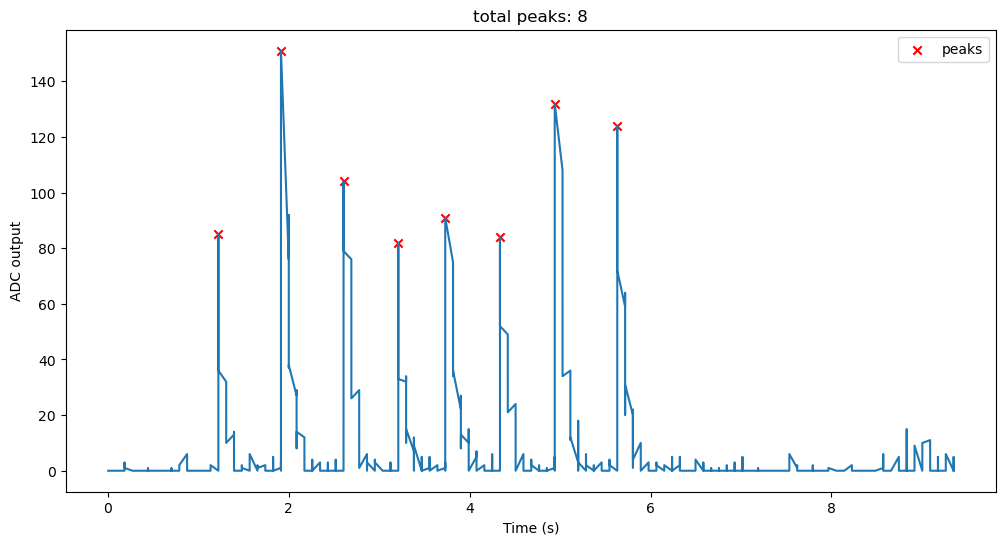

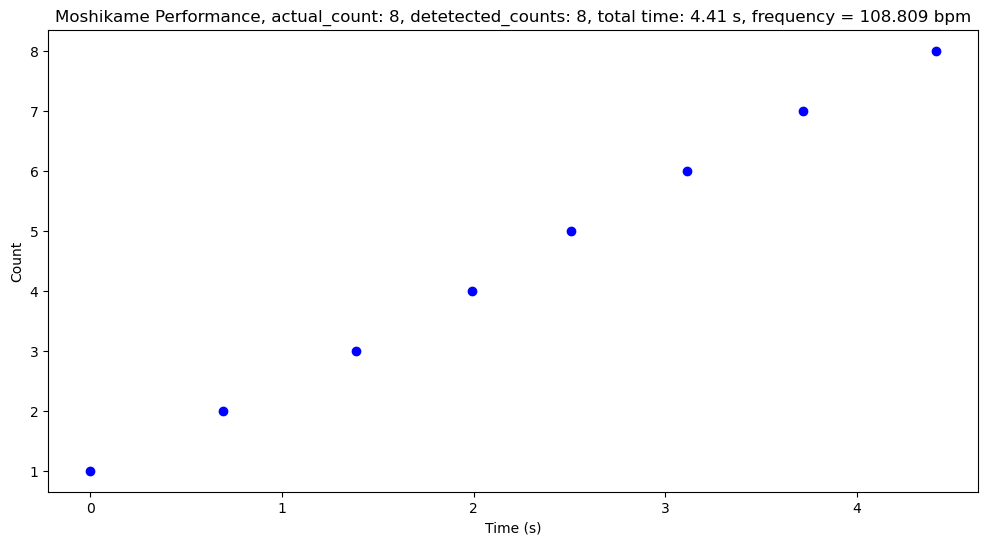

processing file: audiodata_approx30_peaks.csv
time_arr, power_arr length (2097,) (2097,)
peak array shape (30,)
fs= 53092.45569620253
peaks idx [ 160  210  264  313  363  417  472  520  571  620  674  729  782  834
  884  935  982 1035 1080 1129 1180 1227 1278 1326 1378 1430 1483 1535
 1583 1628]


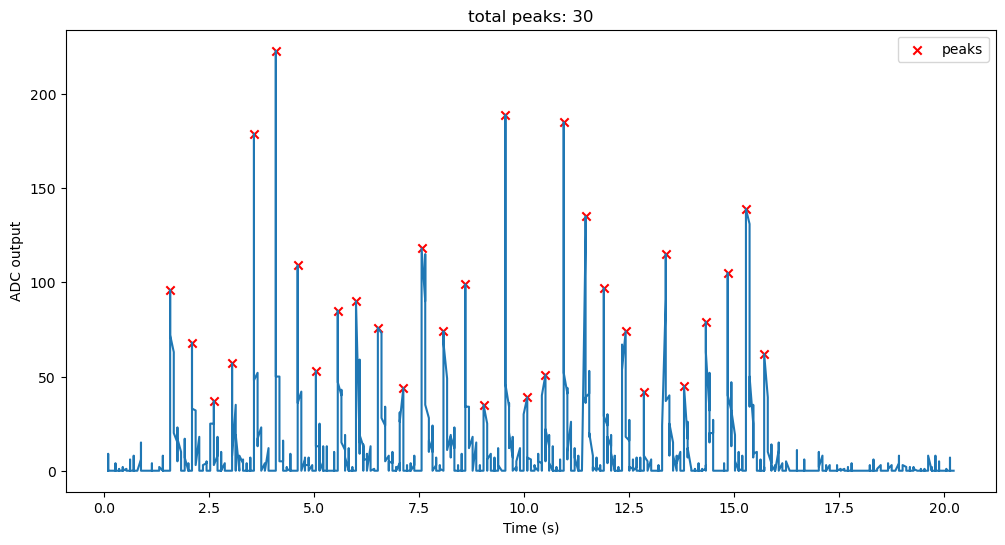

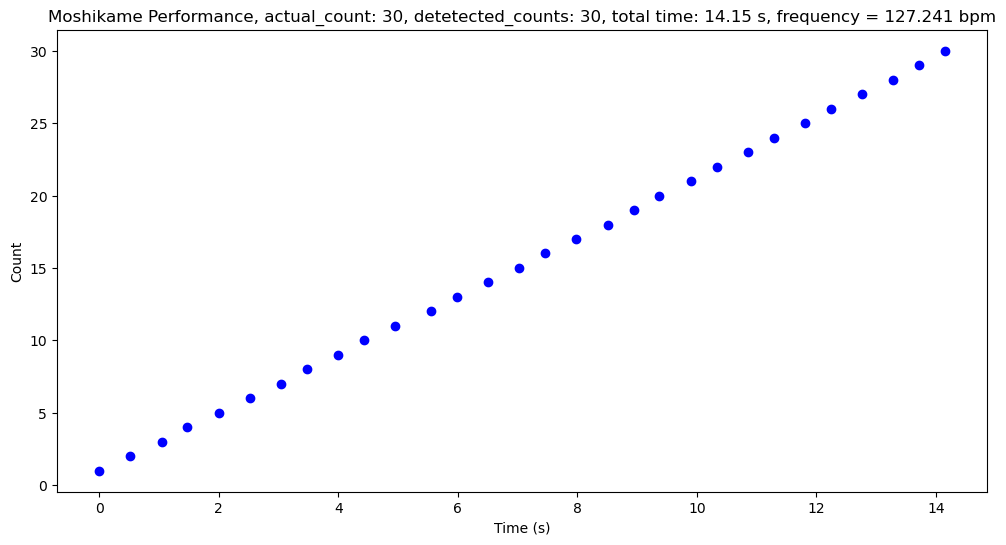

processing file: audiodata43.csv
time_arr, power_arr length (2953,) (2953,)
peak array shape (43,)
fs= 10.62947044035358
peaks idx [ 309  358  407  451  500  546  633  675  717  758  801  842  887  928
  968 1013 1055 1098 1144 1190 1235 1275 1319 1359 1401 1448 1494 1540
 1581 1625 1668 1711 1759 1854 1951 2048 2095 2140 2188 2236 2282 2328
 2379]


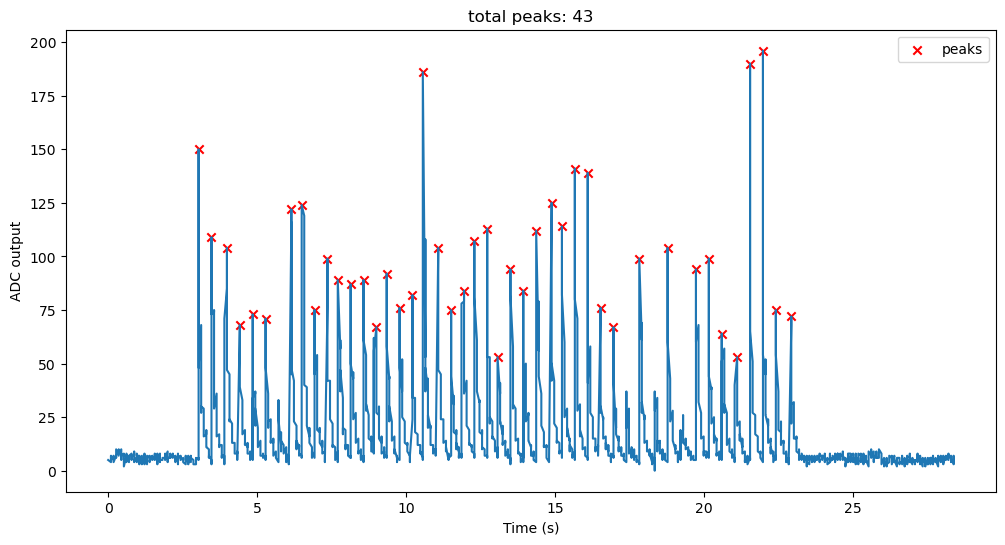

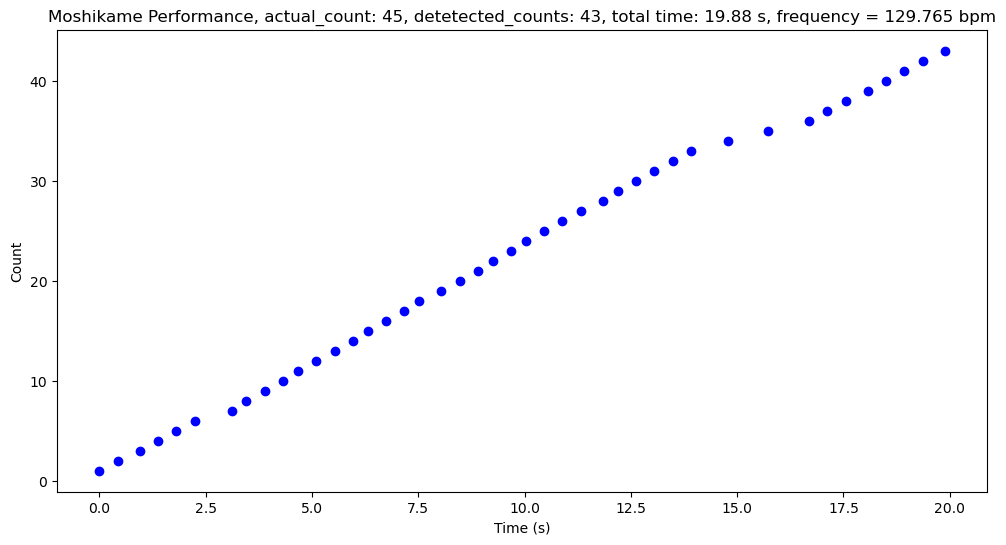

processing file: audiodata_approx100_peaks.csv
time_arr, power_arr length (6040,) (6040,)
peak array shape (94,)
fs= 10.704124132298897
peaks idx [  51  101  289  355  407  458  507  552  605  656  710  798  862  913
  967 1026 1073 1121 1169 1219 1270 1318 1372 1428 1536 1589 1642 1698
 1738 1799 1848 1897 1945 1997 2050 2101 2206 2257 2311 2360 2412 2461
 2559 2611 2662 2712 2813 2915 2968 3015 3073 3114 3168 3220 3271 3367
 3419 3466 3515 3565 3617 3668 3734 3774 3827 3924 3977 4025 4070 4121
 4167 4216 4315 4468 4522 4573 4624 4675 4727 4777 4840 4943 4993 5046
 5145 5193 5245 5294 5349 5402 5459 5520 5735 5876]


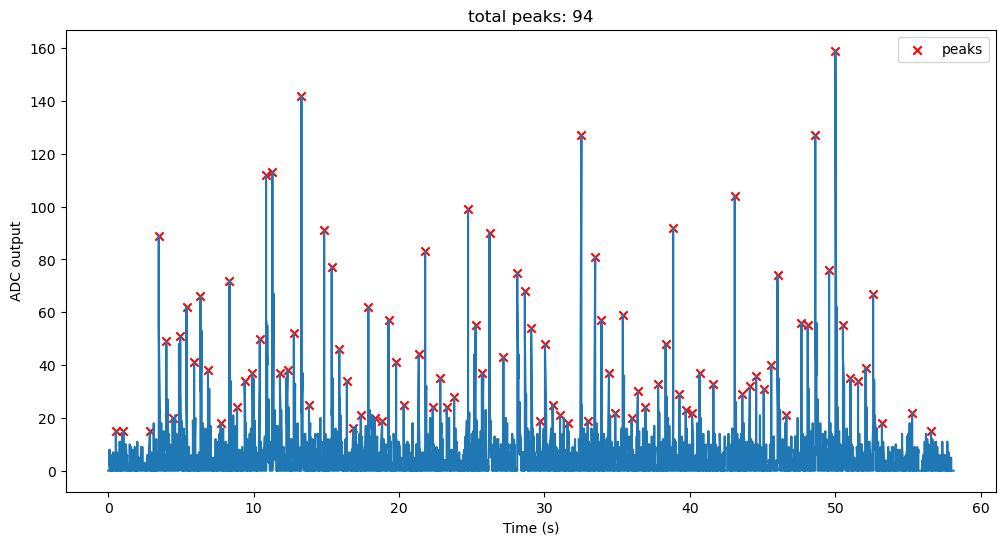

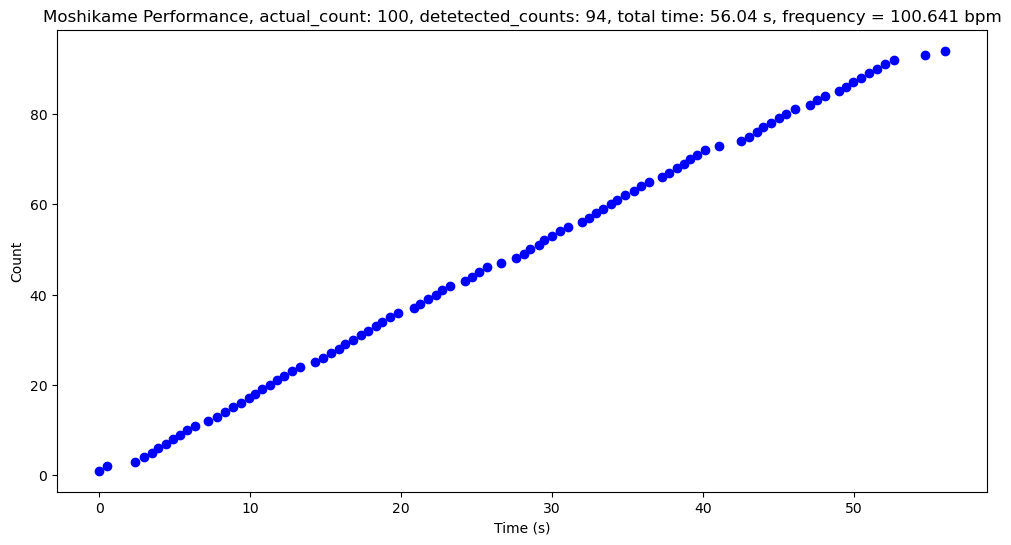

94

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

folder_path = "/Users/harrisonlee/Code/C programming/UBC PHYS 319/project/"

# import data
def count_peaks(filename, actual):
    print("processing file: {}".format(filename))
    data = np.loadtxt(folder_path+filename, delimiter=',')
    time = data[:, 0]
    power = data[:, 1]

    # print(np.mean(power), np.max(power))
    fs = 1/(time[1]-time[0]) # sampling frequency

    # find peaks
    # peaks, props = find_peaks(power, distance=40, height=50)
    # peaks, props = find_peaks(power, distance=20*fs, height=np.max(power[-100:]))
    peaks, props = find_peaks(power, distance=40, height=np.mean(power)+np.std(power))
    print("time_arr, power_arr length", time.shape, power.shape)
    print("peak array shape", peaks.shape)
    print("fs=" ,fs)
    print("peaks idx", peaks)

    # plot 1: audio data with peaks
    plt.figure(figsize=(12, 6))
    plt.plot(time, power)
    plt.scatter(time[peaks], power[peaks], marker='x', c='red', label="peaks")
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("ADC output")
    plt.title("total peaks: {}".format(len(peaks)))
    plt.show()

    # plot 2: performance with total count frequncy
    total_time = time[peaks[-1]] - time[peaks[0]]
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(peaks):
        counts = i + 1
        plt.scatter(time[idx]-time[peaks[0]], counts, c='b')
    plt.xlabel('Time (s)')
    plt.ylabel('Count')
    
    if total_time // 60 == 0:
        plt.title("Moshikame Performance, actual_count: {}, detetected_counts: {}, total time: {:.2f} s, frequency = {:.3f} bpm"
                  .format(actual, counts, total_time % 60, counts / total_time * 60))
    else:
        plt.title("Moshikame Performance, actual_count: {}, detetected_counts: {}, total time: {} min {:.2f} s, frequency = {:.3f} bpm"
                  .format(actual, counts, total_time // 60, total_time % 60, counts / total_time * 60))
    plt.show()
    
    return len(peaks)

file1 = "audiodata8.csv"
file2 = "audiodata_approx30_peaks.csv"
file3 = "audiodata43.csv"
file4 = "audiodata_approx100_peaks.csv"

count_peaks(file1, 8)
count_peaks(file2, 30)
count_peaks(file3, 45)
count_peaks(file4, 100)


## citation
- Japan Kendama Association. (n.d.). Kendama-dō. Japan Kendama Association - English. Retrieved April 9, 2024, from https://kendama.or.jp/english/history/kendama-do/ 

- Problem with mic amplifier + led. (2016, August 20). Arduino Forum. https://forum.arduino.cc/t/problem-with-mic-amplifier-led/402615/10 

- Tuorialspoint. (n.d.). Electronic circuits - clamper circuits. https://www.tutorialspoint.com/electronic_circuits/electronic_clamper_circuits.htm